# Rigorous Thermodynamic Decomposition of Urea's Effects on the Solubility of Polyethylene Glycol
Stefan Hervø-Hansen<sup>a,</sup> and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 3: Analysis

### Introduction
Here we aim to provide a detailed thermodynamic analysis of how urea influence the solvation of polyethylene glycol (PEG). By utilizing molecular dynamics simulations, we can gain atomic insight into the mechanism which underpins the change in excess chemical potential of PEG with the addition of urea. Understanding these effects is crucial for applications in biochemistry and materials science, where PEG and its derivatives are widely used. The following sections detail the methods and materials employed in our simulations and analyses.

### Methods & Materials
Molecular dynamics simulations were conducted using the OpenMM (8.0)[<sup>1</sup>](#fn1) software package. The details of these simulations can be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG, a CHARMM-derived force field (C35r) was utilized, which has previously been shown to reproduce the hydrodynamic radii and shape anisotropy of PEG[<sup>2</sup>](#fn2). The PEG force field was combined with the SPC/E force field for water[<sup>3</sup>](#fn3) and a Kirkwood-Buff derived force field for urea[<sup>4</sup>](#fn4).

The isothermal-isobaric ensemble was sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6) and a Monte Carlo barostat[<sup>7,</sup>](#fn7)[<sup>8</sup>](#fn8). The trajectories were analyzed using MDTraj[<sup>9</sup>](#fn9) for structural properties, while ERmod[<sup>10</sup>](#fn10) was used for the calculation of solvation free energies. The calculation of solvation free energy can be found in the [Part 2 Jupyter notebook](ERmod.ipynb) and the analysis of data can be found in [Part 3 Jupyter notebook](Analysis.ipynb)

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 8: Molecular Dynamics Simulation with Machine Learning Potentials. J. Phys. Chem. B 128, 109–116 (2023). </span><br>
2. <span id="fn2"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
3. <span id="fn3"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
4. <span id="fn4"> S. Weerasinghe, P. E. Smith, A Kirkwood−Buff Derived Force Field for Mixtures of Urea and Water. J. Phys. Chem. B 107, 3891–3898 (2003). </span><br>
5. <span id="fn5"> B. Leimkuhler, C. Matthews, Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proc. R. Soc. A. 472, 20160138 (2016). </span><br>
6. <span id="fn6"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
7. <span id="fn7"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
8. <span id="fn8"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
9. <span id="fn9"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015). </span><br>
10. <span id="fn10"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>

## Import of Python Modules & Auxiliary Functions

In [1]:
#Notebook dependent libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D      
import matplotlib.patheffects as pe
import mdtraj as md
import scipy.optimize as optimize
from uncertainties import unumpy

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"]) 

homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/group1/z44785r/PEO_TMP


### Simulation settings

In [2]:
states = { # State of simulations, (outFreq is steps per frame)
          'conf':{'Nsteps': 500000000, 'OutFreq': 1000}, # 1000 nanoseconds, 500.000 frames
          'sol': {'Nsteps':  25000000, 'OutFreq':  500}, #   50 nanoseconds,  50.000 frames
          'ref': {'Nsteps':  50000000, 'OutFreq':  500}, #  100 nanoseconds, 100.000 frames
         }

nmers = [36] # PEG polymer length
Nparticles = {       # Number of PEG and water molecules. Salt is calculated based on concentration input
    'PEG': 1,
    'Water': 10000,
}
NConfs = 100

urea_reference_concentrations = { 
   0.00: {'P0':    0, 'P1': 378, 'P2': 1472},
   2.00: {'P0':  378, 'P1':   0, 'P2': 1472},
   6.00: {'P0': 1472, 'P1':   0, 'P2':  378},
}

NaCl_reference_concentrations = {
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

## Loading Solvation Free Energies

In [3]:
# Load the Urea results from the disk
slvfe       = np.load('Data/slvfe_PEG_Urea.npy')
slvfe_err   = np.load('Data/slvfe_err_PEG_Urea.npy')
mesh_err    = np.load('Data/mesh_err_PEG_Urea.npy')
self_energy = np.load('Data/self_err_PEG_Urea.npy')

# Load the NaCl results from the disk
slvfe_NaCl       = np.load('Data/slvfe_PEG_NaCl.npy')
slvfe_err_NaCl   = np.load('Data/slvfe_err_PEG_NaCl.npy')
mesh_err_NaCl    = np.load('Data/mesh_err_PEG_NaCl.npy')
self_energy_NaCl = np.load('Data/self_err_PEG_NaCl.npy')

# choose max errors for slefe
max_err = np.maximum.reduce([slvfe_err,mesh_err,self_energy])
max_err_NaCl = np.maximum.reduce([slvfe_err_NaCl,mesh_err_NaCl,self_energy_NaCl])

## Convergence of the change in the excess chemical potential of the solute PEG (Fig 1).

0.04794120657426919 0.049956832260923255 0.03533225448234677
0.06354614215217151 0.06649503665719457 0.07480451453369234
0.07607572144637213 0.07655852704504544 0.06907597008116846
0.15471478671086603 0.16031061555947532 0.17897560968082932
0.24931573039736887 0.2358436084413756 0.28978875095376955
0.30354447911934046 0.29617786043959676 0.29424373208104265


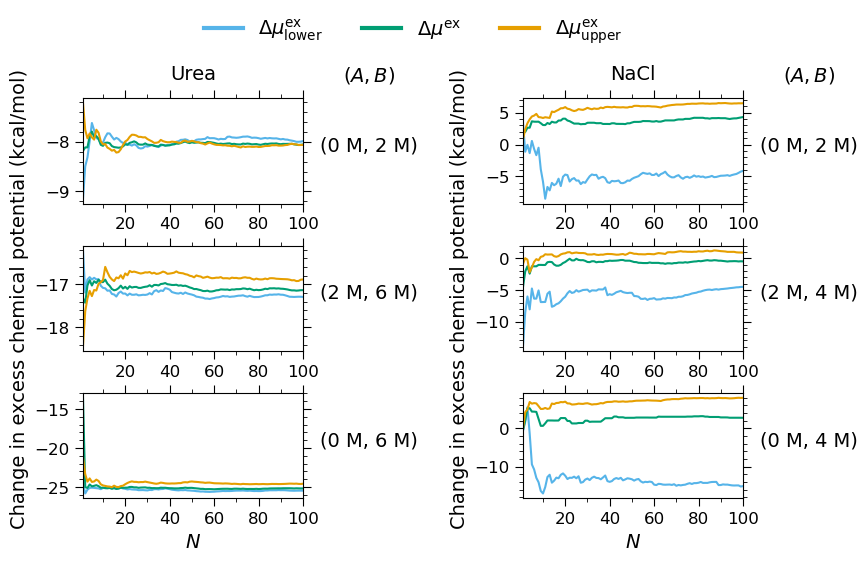

In [4]:
RT = 0.001987 * 298.15

def BAR_solvation_free_energy(D, state_A, state_B, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    # Asign two states
    dSLVFE_AB = state_A[1] - state_A[0]
    dSLVFE_BA = -(state_B[1] - state_B[0])
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

def BAR_error_solvation_free_energy(D, state_A, state_B, state_A_errs, state_B_errs, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    def F(x): # Fermi-Dirac function
        return 1/(1+np.exp(x))
    def FF(x): # Eq. 21
        return -RT*F(x)*F(-x)
    
    # Asign two states (Propagation of errors)
    dSLVFE_AB = unumpy.uarray(state_A[1], state_A_errs[1]) - unumpy.uarray(state_A[0], state_A_errs[0])
    dSLVFE_BA = -(unumpy.uarray(state_B[1], state_B_errs[1]) - unumpy.uarray(state_B[0], state_B_errs[0]))
    
    # Calculate the denominator of Eq. 20
    nominators = []
    denominator = 0
    for slvfe in [*unumpy.nominal_values(dSLVFE_AB), *unumpy.nominal_values(dSLVFE_BA)]:
        value = FF(D-slvfe)
        denominator += value
        nominators.append(value)
        
    # Summuation of the error (Eq. 19)
    BAR_error = 0
    for C, slvfe_err in zip(nominators, [*unumpy.std_devs(dSLVFE_AB), *unumpy.std_devs(dSLVFE_BA)]):
        BAR_error+= (C/denominator)**2 * slvfe_err**2
    return float(np.sqrt(BAR_error))


# Start with a square Figure.
fig = plt.figure(figsize=(11, 5))
gs1 = fig.add_gridspec(nrows=3, ncols=2, left=0.1, right=0.3, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)
gs2 = fig.add_gridspec(nrows=3, ncols=2, left=0.5, right=0.7, bottom=0.1, top=0.9, wspace=0.05, hspace=0.4)

urea_axes = [fig.add_subplot(gs1[0, 0:]), fig.add_subplot(gs1[1, 0:]), fig.add_subplot(gs1[2, 0:])]
NaCl_axes = [fig.add_subplot(gs2[0, 0:]), fig.add_subplot(gs2[1, 0:]), fig.add_subplot(gs2[2, 0:])]

# Plot the data
for ctrl, (data,err) in enumerate(zip([slvfe, slvfe_NaCl], [max_err, max_err_NaCl])):
    lower = np.zeros(shape=NConfs)
    bar   = np.zeros(shape=NConfs)
    upper = np.zeros(shape=NConfs)
    
    lower_err = np.zeros(shape=NConfs)
    bar_err   = np.zeros(shape=NConfs)
    upper_err = np.zeros(shape=NConfs)
    k = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if j > i:
                for N in range(1,NConfs+1):
                    
                    # BAR
                    a = np.stack((data[i,i,0:N], data[i,j,0:N]), axis=0)
                    b = np.stack((data[j,j,0:N], data[j,i,0:N]), axis=0)
                    
                    a_err = np.stack((err[i,i,0:N], err[i,j,0:N]), axis=0)
                    b_err = np.stack((err[j,j,0:N], err[j,i,0:N]), axis=0)
                    
                    initial_guess = ((data[i,j,:N].mean()-data[i,i,:N].mean())+
                                     (data[j,j,:N].mean()-data[j,i,:N].mean()))/2
                    
                    result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                               args=(a,b,298.15))
                    
                    bar[N-1] = result.x[0]*RT
                    bar_err[N-1] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err)
                    
                    # LOWER
                    a = unumpy.uarray(data[j,i,0:N], err[j,i,0:N])
                    b = unumpy.uarray(data[j,j,0:N], err[j,j,0:N])
                    
                    lower[N-1] = unumpy.nominal_values( -(a.mean() - b.mean()) )
                    lower_err[N-1] = unumpy.std_devs( -(a.mean() - b.mean()) )
                    
                    # UPPER
                    a = unumpy.uarray(data[i,j,0:N], err[i,j,0:N])
                    b = unumpy.uarray(data[i,i,0:N], err[i,i,0:N])
                    
                    upper[N-1] = unumpy.nominal_values(a.mean() - b.mean())
                    upper_err[N-1] = unumpy.std_devs(a.mean() - b.mean())
                    if N == 49:
                        print(lower_err[N-1], upper_err[N-1], bar_err[N-1])
                    
                x = np.arange(1, NConfs+1)
                if ctrl == 0:
                    urea_axes[k].plot(x, lower, color='C1')
                    urea_axes[k].plot(x, bar, color='C2')
                    urea_axes[k].plot(x, upper, color='C0')
                    
                    #urea_axes[k].errorbar(x, lower, lower_err, color='C0', markersize=0, linestyle="None")
                    #urea_axes[k].errorbar(x, bar, bar_err, color='C1', markersize=0, linestyle="None")
                    #urea_axes[k].errorbar(x, upper, upper_err, color='C2', markersize=0, linestyle="None")
                    k+=1
                if ctrl == 1:
                    l = NaCl_axes[k].plot(x, lower, color='C1')
                    b = NaCl_axes[k].plot(x, bar, color='C2')
                    u = NaCl_axes[k].plot(x, upper, color='C0')
                    
                    #NaCl_axes[k].errorbar(x, lower, lower_err, color='C0', markersize=0, linestyle="None")
                    #NaCl_axes[k].errorbar(x, bar, bar_err, color='C1', markersize=0, linestyle="None")
                    #NaCl_axes[k].errorbar(x, upper, upper_err, color='C2', markersize=0, linestyle="None")
                    k+=1
                    
pos1 = urea_axes[1].get_position()
urea_axes[1].set_position(urea_axes[2].get_position())
urea_axes[2].set_position(pos1)

urea_axes[0].text(1.30, 1.17, '$(A, B)$',  transform=urea_axes[0].transAxes, fontsize=14, horizontalalignment='center')
urea_axes[0].text(1.30, 0.5, '(0 M, 2 M)', transform=urea_axes[0].transAxes, fontsize=14, horizontalalignment='center')
urea_axes[2].text(1.30, 0.5, '(2 M, 6 M)', transform=urea_axes[2].transAxes, fontsize=14, horizontalalignment='center')
urea_axes[1].text(1.30, 0.5, '(0 M, 6 M)', transform=urea_axes[1].transAxes, fontsize=14, horizontalalignment='center')

pos1 = NaCl_axes[1].get_position()
NaCl_axes[1].set_position(NaCl_axes[2].get_position())
NaCl_axes[2].set_position(pos1)

NaCl_axes[0].text(1.30, 1.17, '$(A, B)$',  transform=NaCl_axes[0].transAxes, fontsize=14, horizontalalignment='center')
NaCl_axes[0].text(1.30, 0.5, '(0 M, 2 M)', transform=NaCl_axes[0].transAxes, fontsize=14, horizontalalignment='center')
NaCl_axes[2].text(1.30, 0.5, '(2 M, 4 M)', transform=NaCl_axes[2].transAxes, fontsize=14, horizontalalignment='center')
NaCl_axes[1].text(1.30, 0.5, '(0 M, 4 M)', transform=NaCl_axes[1].transAxes, fontsize=14, horizontalalignment='center')

urea_axes[0].set_title('Urea', pad=14, fontsize=14)
NaCl_axes[0].set_title('NaCl', pad=14, fontsize=14)

urea_axes[2].set_ylabel('Change in excess chemical potential (kcal/mol)', fontsize=14)
NaCl_axes[2].set_ylabel('Change in excess chemical potential (kcal/mol)', fontsize=14)
urea_axes[1].set_xlabel('$N$', fontsize=14)
NaCl_axes[1].set_xlabel('$N$', fontsize=14)

xtick_major = [0, 20, 40, 60, 80, 100]
xtick_minor = [10, 30, 50, 70, 90]

#urea_axes[0].set_ylim(-8.7, -5.2)
#urea_axes[1].set_ylim(-27, -22)
#urea_axes[2].set_ylim(-20, -14.5)
#NaCl_axes[1].set_ylim(-35, 24)

for ax in [*NaCl_axes, *urea_axes]:
    ax.minorticks_on()
    ax.set_xticks(ticks=xtick_major, minor=False)
    ax.set_xticks(ticks=xtick_minor, minor=True)
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=12, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=3)
    ax.set_xlim(1,100)


lower_patch = Line2D([], [], color='C1', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2', lw=3, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch], loc='lower center', ncol=3, fontsize=14,
           bbox_to_anchor=(0.4, 0.97), frameon=False)

fig.savefig('Figures/slvfe_convergence.pdf', bbox_inches='tight')
fig.savefig('Figures/slvfe_convergence.png', bbox_inches='tight', dpi=600)

## Estimation of the excess free energy from the thermodynamic cycle

In [5]:
k = 0

lower = np.zeros(shape=(2,3))
bar   = np.zeros(shape=(2,3))
upper = np.zeros(shape=(2,3))

lower_err = np.zeros((2,3))
bar_err   = np.zeros((2,3))
upper_err = np.zeros((2,3))


for data,err in zip([slvfe, slvfe_NaCl], [max_err, slvfe_err_NaCl]):
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if j > i:
                # BAR
                a = np.stack((data[i,i], data[i,j]), axis=0)
                b = np.stack((data[j,j], data[j,i]), axis=0)
                
                a_err = np.stack((err[i,i], err[i,j]), axis=0)
                b_err = np.stack((err[j,j], err[j,i]), axis=0)
                
                initial_guess = ((data[i,j].mean()-data[i,i].mean())+
                                 (data[j,j].mean()-data[j,i].mean()))/2
                
                result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                           args=(a,b,298.15))
                
                bar[k//3,k%3] = result.x[0]*RT
                bar_err[k//3,k%3] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err)
                
                # LOWER
                a = unumpy.uarray(data[j,i], err[j,i])
                b = unumpy.uarray(data[j,j,], err[j,j])
                
                lower[k//3,k%3] = unumpy.nominal_values( -(a.mean() - b.mean()) )
                lower_err[k//3,k%3] = unumpy.std_devs( -(a.mean() - b.mean()) )
                
                # UPPER
                a = unumpy.uarray(data[i,j], err[i,j])
                b = unumpy.uarray(data[i,i], err[i,i])
                
                upper[k//3,k%3] = unumpy.nominal_values(a.mean() - b.mean())
                upper_err[k//3,k%3] = unumpy.std_devs(a.mean() - b.mean())
                k +=1
                
lower = unumpy.uarray(lower, lower_err)
bar   = unumpy.uarray(bar, bar_err)
upper = unumpy.uarray(upper, upper_err)

labels = ['lower (Urea)','lower (NaCl)','BAR (Urea)','BAR (NaCl)','upper (Urea)','upper (NaCl)']
print('State    \t:\t 0 to 2 \t+\t 2 to max \t-\t 0 to max\t=\tcycle energy')
print('===============================================================================================================')
for i, a in enumerate([*lower, *bar, *upper]):
    excess_free_energy = a[0] + a[2] - a[1]
    print('{}\t:\t{}\t+\t{}\t-\t{}\t=\t{}'.format(labels[i], a[0], a[2], a[1], excess_free_energy))

State    	:	 0 to 2 	+	 2 to max 	-	 0 to max	=	cycle energy
lower (Urea)	:	-7.987+/-0.035	+	-17.29+/-0.05	-	-25.48+/-0.04	=	0.20+/-0.08
lower (NaCl)	:	-4.13+/-0.09	+	-4.51+/-0.19	-	-15.06+/-0.14	=	6.43+/-0.25
BAR (Urea)	:	-8.055+/-0.025	+	-17.14+/-0.04	-	-25.19+/-0.05	=	0.00+/-0.07
BAR (NaCl)	:	4.32+/-0.12	+	-0.48+/-0.18	-	2.75+/-0.20	=	1.08+/-0.30
upper (Urea)	:	-8.064+/-0.035	+	-16.89+/-0.05	-	-24.59+/-0.05	=	-0.36+/-0.08
upper (NaCl)	:	6.48+/-0.11	+	0.91+/-0.18	-	7.96+/-0.15	=	-0.57+/-0.25


## Probability distribution function of the radius of gyration of the PEG solute upon variation of the solvent condition (Fig 2).

In [6]:
%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for urea_reference in urea_reference_concentrations.items():
        C = '{0:.2f}'.format(urea_reference[0])
        %cd -q $homedir/Simulations/$nmerdir/$C/Solute
            
        traj = md.load_xtc('trajectory_dry.xtc', top=homedir+'/PDB_files/PEO-36-mer.pdb')
        PEG_atoms = traj.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
        traj_PEG = traj.atom_slice(PEG_atoms)
        rg = md.compute_rg(traj_PEG)
        np.save('{}/Data/Rg_PEG36_Urea_{}.npy'.format(homedir,C), rg)

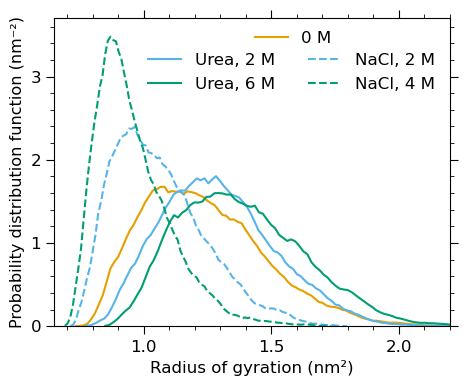

In [7]:
%cd -q $homedir
fig, ax = plt.subplots(figsize=(5.1, 4))

Nblocks = 4
Nbins = 100
lines = []

sampled_concs = [0,2,6,0,2,4]

for i, conc in enumerate([*urea_reference_concentrations.keys(), *NaCl_reference_concentrations.keys()]):
    if i == 0:
        Rg_data = np.load('Data/Rg_PEG36_Urea_0.00.npy')
        linestyle = 'solid'
        label = '0 M'
    elif i == 3:
        continue
    else:
        if i > 2:
            cosolvent = 'NaCl'
            linestyle = 'dashed'
        else:
            cosolvent = 'Urea'
            linestyle = 'solid'
        label = '{0}, {1:.0f} M'.format(cosolvent, sampled_concs[i])
        fname = 'Rg_PEG36_{0:}_{1:.2f}.npy'.format(cosolvent, conc)
        Rg_data = np.load('Data/'+fname)
        
    Rg_data = Rg_data.reshape((Nblocks, len(Rg_data)//Nblocks))
    densities = np.zeros(shape=(Nblocks,Nbins))
    
    for j, rg in enumerate(Rg_data):
        density, edges = np.histogram(rg, bins=Nbins, density=True, range=(Rg_data.min(), Rg_data.max()))
        densities[j,:] = density
    
    centers = (edges[:-1]+edges[1:])/2
    
    line = ax.plot(centers, densities.mean(axis=0), label=label, linestyle=linestyle, color='C{}'.format(i%3))
#    ax.fill_between(centers,
#                    y1=densities.mean(axis=0)-densities.std(axis=0)/np.sqrt(Nblocks),
#                    y2=densities.mean(axis=0)+densities.std(axis=0)/np.sqrt(Nblocks),
#                    color='C{}'.format(i%3), alpha=0.2)
    lines.append(line[0])
    
legend = ax.legend(handles=lines[1:], frameon=False, ncols=2, loc=(0.22, 0.74), fontsize=12)
ax.add_artist(legend)
ax.legend(handles=lines[0:1], frameon=False, loc=(0.49, 0.89), fontsize=12)
ax.set_xlabel('Radius of gyration (nm²)', fontsize=12)
ax.set_ylabel('Probability distribution function (nm⁻²)', fontsize=11.6)
ax.tick_params(axis='both', which='major', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

xtick_major = [1.0, 1.5, 2.0]
xtick_minor = [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.1, 2.2]

ax.minorticks_on()
ax.set_xticks(ticks=xtick_major, minor=False)
ax.set_xticks(ticks=xtick_minor, minor=True)
ax.locator_params(axis='y', nbins=6)

ax.set_ylim(0, 3.7)
ax.set_xlim(0.65, 2.2)

fig.savefig('Figures/structural_changes.pdf', bbox_inches='tight')
fig.savefig('Figures/structural_changes.png', bbox_inches='tight', dpi=600)

## Probability distribution functions of the change in the solvation free energy upon variation of the solvent condition (Fig 3).

0,0 -> 0,1
0,0 -> 0,2
1,1 -> 1,2
0,0 -> 0,1
0,0 -> 0,2
1,1 -> 1,2


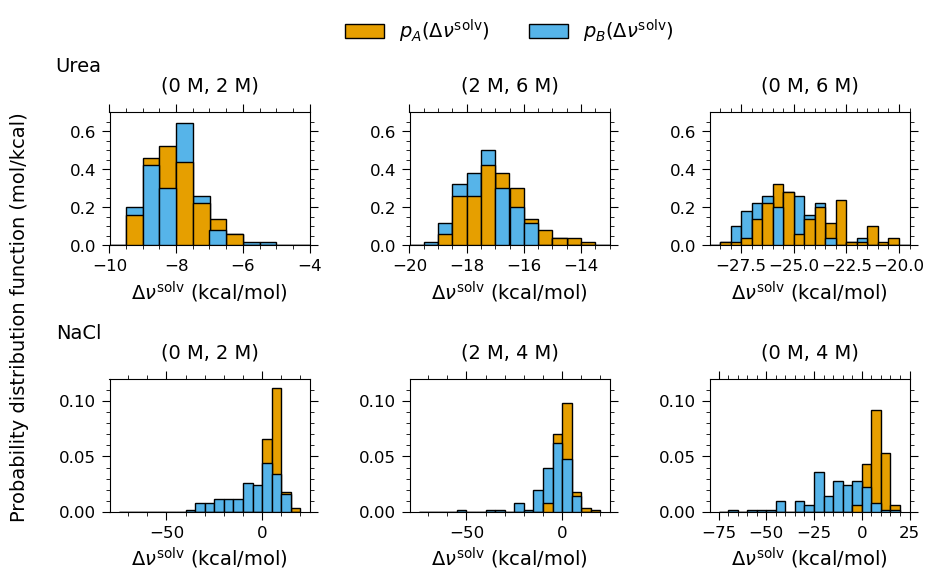

In [34]:
def gauss(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

# Start with a square Figure.
fig = plt.figure(figsize=(10, 5))
gs1 = fig.add_gridspec(2, 3, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=1.0)

# Create the Axes.
urea_axes = [fig.add_subplot(gs1[0, 0]), fig.add_subplot(gs1[0, 1]), fig.add_subplot(gs1[0, 2])]
NaCl_axes = [fig.add_subplot(gs1[1, 0]), fig.add_subplot(gs1[1, 1]), fig.add_subplot(gs1[1, 2])]


for k, (ax, slvfe_set) in enumerate(zip([urea_axes,NaCl_axes],[slvfe,slvfe_NaCl])):
    ctrl = 0
    for i in range(slvfe_set.shape[0]):
        for j in range(slvfe_set.shape[1]):
            if j > i:
                print('{},{} -> {},{}'.format(i,i,i,j))
                a = np.stack((slvfe_set[i,i], slvfe_set[i,j]), axis=0)
                b = np.stack((slvfe_set[j,j], slvfe_set[j,i]), axis=0)
                dSLVFE_AB = a[1] - a[0]
                dSLVFE_BA = -(b[1] - b[0])
                if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                    continue
                lower = min([min(dSLVFE_AB), min(dSLVFE_BA)])
                upper = max([max(dSLVFE_AB), max(dSLVFE_BA)])
                if k == 0:
                    bins = np.arange(-30, -3, 0.5)
                else:
                    bins = np.arange(-75, 25, 5)
                ax[ctrl].hist(dSLVFE_AB, density=True, bins=bins, ec='black')
                hist = ax[ctrl].hist(dSLVFE_BA, density=True, bins=bins, ec='black')

                for bars in zip(*ax[ctrl].containers):
                    order = np.argsort(np.argsort([b.get_height() for b in bars]))
                    for bar, bar_order in zip(bars, order):
                        bar.set_zorder(2 + len(ax[ctrl].containers) - bar_order)
                ctrl+=1
    
# Beautification
fig.text(0.01, 0.49, s='Probability distribution function (mol/kcal)', horizontalalignment='center',
         verticalalignment='center', rotation='vertical', fontsize=14)
    
urea_axes[0].set_xlim(-10, -4)
urea_axes[1].set_xlim(-29, -19.5)
urea_axes[2].set_xlim(-20, -13)

#NaCl_axes[0].set_xlim(-45, 25)
#NaCl_axes[1].set_xlim(-80, 25)
#NaCl_axes[2].set_xlim(-60, 25)

pos1 = urea_axes[1].get_position()
urea_axes[1].set_position(urea_axes[2].get_position())
urea_axes[2].set_position(pos1)

pos1 = NaCl_axes[1].get_position()
NaCl_axes[1].set_position(NaCl_axes[2].get_position())
NaCl_axes[2].set_position(pos1)

titles = ['(0 M, 2 M)', '(0 M, 6 M)', '(2 M, 6 M)', '(0 M, 2 M)', '(0 M, 4 M)', '(2 M, 4 M)']
for i, ax in enumerate([*urea_axes, *NaCl_axes]):
    ax.minorticks_on()
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=12, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=3)
    ax.set_xlabel(r'$\Delta\nu^{\mathrm{solv}}$'f' (kcal/mol)', fontsize=14)
    ax.set_title(titles[i], fontsize=14, pad=15)

NaCl_axes[1].set_xticks(ticks=[-75, -50, -25, 0, 25], minor=False)
#urea_axes[1].set_xticks(ticks=[-29,-26,-23,-20], minor=False)
#NaCl_axes[1].set_xlim(-80, 25)

for ax in NaCl_axes:
    ax.set_ylim(0, 0.12)
    
for ax in urea_axes:
    ax.set_ylim(0, 0.7)
    
urea_axes[0].text(-0.04, 1.3, 'Urea', transform=urea_axes[0].transAxes, fontsize=14, horizontalalignment='right')
NaCl_axes[0].text(-0.04, 1.3, 'NaCl', transform=NaCl_axes[0].transAxes, fontsize=14, horizontalalignment='right')

PA = mpatches.Patch(facecolor='C0', edgecolor='black', lw=1, label=r'$p_A(\Delta\nu^{\mathrm{solv}})$')
PB = mpatches.Patch(facecolor='C1', edgecolor='black', lw=1, label=r'$p_B(\Delta\nu^{\mathrm{solv}})$')

fig.legend(handles=[PA, PB], loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.00), frameon=False)
fig.savefig('Figures/histograms_v2.pdf', bbox_inches='tight')

0.4404799999999991
0.8239699999999992
0.5804699999999983
5.651710000000001
11.097989999999996
6.953380000000003


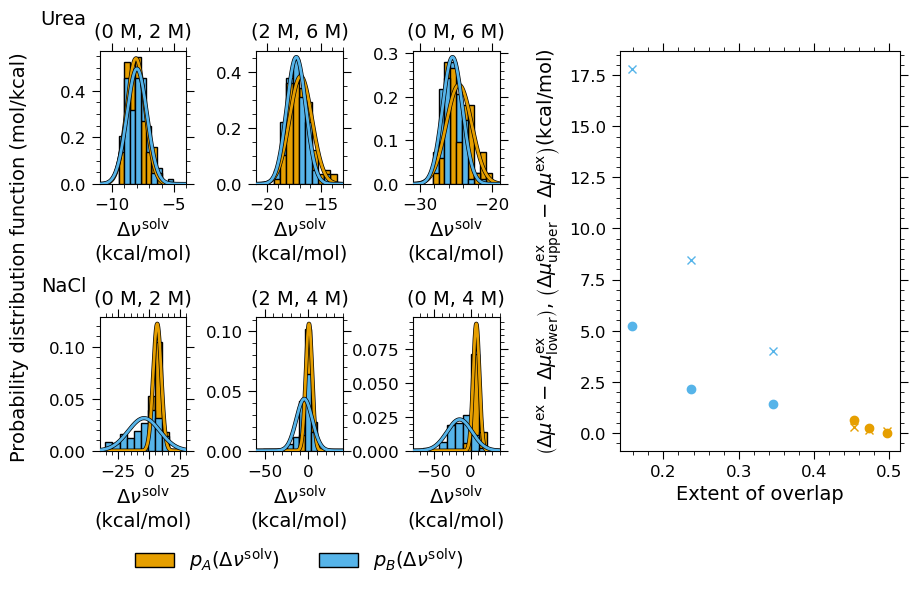

In [35]:
def gauss(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

# Start with a square Figure.
fig = plt.figure(figsize=(10, 5))
gs1 = fig.add_gridspec(2, 3, left=0.1, right=0.5, bottom=0.1, top=0.9, wspace=0.8, hspace=1.0)
gs2 = fig.add_gridspec(2, 2, left=0.62, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Create the Axes.
urea_axes = [fig.add_subplot(gs1[0, 0]), fig.add_subplot(gs1[0, 1]), fig.add_subplot(gs1[0, 2])]
NaCl_axes = [fig.add_subplot(gs1[1, 0]), fig.add_subplot(gs1[1, 1]), fig.add_subplot(gs1[1, 2])]
err_ax = fig.add_subplot(gs2[0:,0:])

for ax, slvfe_set in zip([urea_axes,NaCl_axes],[slvfe,slvfe_NaCl]):
    ctrl = 0
    for i in range(slvfe_set.shape[0]):
        for j in range(slvfe_set.shape[1]):
            if j > i:
                a = np.stack((slvfe_set[i,i], slvfe_set[i,j]), axis=0)
                b = np.stack((slvfe_set[j,j], slvfe_set[j,i]), axis=0)
                dSLVFE_AB = a[1] - a[0]
                dSLVFE_BA = -(b[1] - b[0])
                if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                    continue
                
                lower = min([min(dSLVFE_AB), min(dSLVFE_BA)])
                upper = max([max(dSLVFE_AB), max(dSLVFE_BA)])
                ax[ctrl].hist(dSLVFE_AB, density=True, bins=10, range=(lower, upper), ec='black')
                hist = ax[ctrl].hist(dSLVFE_BA, density=True, bins=10, range=(lower, upper), ec='black')
                print(hist[1][1]-hist[1][0])

                for bars in zip(*ax[ctrl].containers):
                    order = np.argsort(np.argsort([b.get_height() for b in bars]))
                    for bar, bar_order in zip(bars, order):
                        bar.set_zorder(2 + len(ax[ctrl].containers) - bar_order)
                
                d = np.zeros(shape=(2,10000000))
                for k, energies in enumerate([dSLVFE_AB,dSLVFE_BA]):
                    mean = energies.mean()
                    sigma = energies.std()
                    x = np.arange(-100, 100, 0.01)
                    if k == 0:
                        color = 'C0'
                    else:
                        color = 'C1'
                    ax[ctrl].plot(x,gauss(x,mean,sigma), color=color, zorder=1e10, linewidth=2,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
                ctrl+=1
                
                
for k, data_set in enumerate([slvfe,slvfe_NaCl]):
    y1 = []
    y2 = []
    x = []
    for i in range(data_set.shape[0]):
        for j in range(data_set.shape[1]):
            if j > i:
                a = np.stack((data_set[i,i], data_set[i,j]), axis=0)
                b = np.stack((data_set[j,j], data_set[j,i]), axis=0)
                dSLVFE_AB = a[1] - a[0]
                dSLVFE_BA = -(b[1] - b[0])
                if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                    continue
                    
                initial_guess = ((data_set[i,j].mean()-data_set[i,i].mean())+
                                 (data_set[j,j].mean()-data_set[j,i].mean()))/2
                    
                result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                               args=(a,b,298.15))
                    
                bar = result.x[0]*RT
                
                d = np.zeros(shape=(2,10000000))
                for h, energies in enumerate([dSLVFE_AB, dSLVFE_BA]):
                    mean = energies.mean()
                    sigma = energies.std()
                    xs = np.arange(-5000, 5000, 0.001)
                    density = gauss(xs, mean, sigma)
                    d[h,:] = density * 0.001
                    
                overlap = 0
                for densities in d.T:
                    if densities[0] == 0 and densities[1] == 0:
                        continue
                    overlap += densities[0]*densities[1] / (densities[0]+densities[1])
                
                y1.append(abs(dSLVFE_AB.mean()-bar))
                y2.append(abs(dSLVFE_BA.mean()-bar))
                x.append(overlap)
    
    if k == 0:
        color = 'C0'
    else:
        color = 'C1'
    err_ax.plot(x,y1, linestyle='None', marker='o', color=color)
    err_ax.plot(x,y2, linestyle='None', marker='x', color=color)
    
# Beautification

fig.text(0.02, 0.49, s='Probability distribution function (mol/kcal)', horizontalalignment='center',
         verticalalignment='center', rotation='vertical', fontsize=14)
    
urea_axes[0].set_xlim(-11, -4)
urea_axes[1].set_xlim(-31, -19)
urea_axes[2].set_xlim(-21, -13)

NaCl_axes[0].set_xlim(-40, 30)
NaCl_axes[1].set_xlim(-80, 40)
NaCl_axes[2].set_xlim(-60, 40)

pos1 = urea_axes[1].get_position()
urea_axes[1].set_position(urea_axes[2].get_position())
urea_axes[2].set_position(pos1)

pos1 = NaCl_axes[1].get_position()
NaCl_axes[1].set_position(NaCl_axes[2].get_position())
NaCl_axes[2].set_position(pos1)

titles = ['(0 M, 2 M)', '(0 M, 6 M)', '(2 M, 6 M)', '(0 M, 2 M)', '(0 M, 4 M)', '(2 M, 4 M)']
for i, ax in enumerate([*urea_axes, *NaCl_axes]):
    ax.minorticks_on()
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=12, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=3)
    ax.set_xlabel(r'$\Delta\nu^{\mathrm{solv}}$'f'\n(kcal/mol)', fontsize=14)
    ax.set_title(titles[i], fontsize=14, pad=10)
    
urea_axes[0].text(-0.15, 1.2, 'Urea', transform=urea_axes[0].transAxes, fontsize=14, horizontalalignment='right')
NaCl_axes[0].text(-0.15, 1.2, 'NaCl', transform=NaCl_axes[0].transAxes, fontsize=14, horizontalalignment='right')
    
err_ax.set_ylabel(r'$\left( \Delta\mu^{\mathrm{ex}} - \Delta\mu^{\mathrm{ex}}_{\mathrm{lower}} \right)$, '
                  r'$\left( \Delta\mu^{\mathrm{ex}}_{\mathrm{upper}} - \Delta\mu^{\mathrm{ex}} \right)$'
                  r'(kcal/mol)', fontsize=14)

err_ax.set_xlabel('Extent of overlap', fontsize=14)
err_ax.minorticks_on()
err_ax.yaxis.set_ticks_position('both')
err_ax.xaxis.set_ticks_position('both')
err_ax.tick_params(axis='both', which='major', labelsize=12, length=6)
err_ax.tick_params(axis='both', which='minor', labelsize=12, length=3)

PA = mpatches.Patch(facecolor='C0', edgecolor='black', lw=1, label=r'$p_A(\Delta\nu^{\mathrm{solv}})$')
PB = mpatches.Patch(facecolor='C1', edgecolor='black', lw=1, label=r'$p_B(\Delta\nu^{\mathrm{solv}})$')

fig.legend(handles=[PA, PB], loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.3, -0.18), frameon=False)
fig.savefig('Figures/histograms.pdf', bbox_inches='tight')

# RESEARCH NOTES (WILL BE DELETED UPON FINISHING)

## Table generation

In [ ]:
RT = 0.001987 * 298.15
print('Transition | Lower limit |     BAR    | Upper limit')

keys = list(urea_reference_concentrations.keys())

for i in range(slvfe.shape[0]):
    for j in range(slvfe.shape[1]):
        if j > i:
            a = np.stack((slvfe[i,i], slvfe[i,j]), axis=0)
            b = np.stack((slvfe[j,j], slvfe[j,i]), axis=0)
            initial_guess = ((slvfe[i,j].mean()-slvfe[i,i,].mean())+
                             (slvfe[j,j].mean()-slvfe[j,i,].mean()))/2
            result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                       args=(a,b,298.15))
            if result.x[0] == 0:
                result.x[0] = np.nan
            print('{} → {}  | {:11.4f} | {:8.4f}   | {:2.4f}'.format(keys[i], keys[j],
                                                                    -(slvfe[j,i].mean()-slvfe[j,j].mean()),
                                                                    result.x[0]*RT,
                                                                    slvfe[i,j].mean()-slvfe[i,i].mean()))

In [ ]:
RT = 0.001987 * 298.15

keys = list(urea_reference_concentrations.keys())
for i in range(slvfe.shape[0]):
    for j in range(slvfe.shape[1]):
        if j > i:
            print('Transition: {} → {}'.format(keys[i], keys[j]))
            print('Lower limit |     BAR    | Upper limit')
            Table = np.zeros(shape=(3,slvfe.shape[2]))
            for Nconfs in range(1,21):
                a = np.stack((slvfe[i,i,0:Nconfs], slvfe[i,j,0:Nconfs]), axis=0)
                b = np.stack((slvfe[j,j,0:Nconfs], slvfe[j,i,0:Nconfs]), axis=0)
                initial_guess = ((slvfe[i,j,:Nconfs].mean()-slvfe[i,i,:Nconfs].mean())+
                                 (slvfe[j,j,:Nconfs].mean()-slvfe[j,i,:Nconfs].mean()))/2
                result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess, args=(a,b,298.15),
                                           tol=1e-100)
                Table[0,Nconfs-1] = -(slvfe[j,i,0:Nconfs].mean()-slvfe[j,j,0:Nconfs].mean()) # lower limit
                Table[1,Nconfs-1] = result.x[0]*RT
                Table[2,Nconfs-1] = slvfe[i,j,0:Nconfs].mean()-slvfe[i,i,0:Nconfs].mean() # upper limit
            for line in Table.T:
                print('{:11.4f} | {:8.4f}   | {:2.4f}'.format(*line))
            print('')

In [ ]:
Na = 6.02214076e23
nm3_to_l = 1e-24

for i, (C, perturb) in enumerate(urea_reference_concentrations.items()):
    C = '{0:.2f}'.format(C)
    if C == '0.00':
        continue
    else:
        dirc = '{homedir}/Simulations/References/{conc}/output.dat'.format(homedir=homedir, conc=C)
    vol_data = np.loadtxt(dirc, usecols=4, skiprows=1)
    avgVolume = vol_data.mean()
    Nions = perturb['P0']
    print(Nions/(avgVolume*Na*nm3_to_l))
    print(Nions)